In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git 
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate

In [2]:
from datasets import (
    load_dataset, 
    DatasetDict, 
    Dataset, 
    concatenate_datasets)
from collections import Counter
from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer, 
    EarlyStoppingCallback)
from peft import (
    PeftModel, 
    PeftConfig, 
    get_peft_model, 
    LoraConfig)
import evaluate
import torch
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
dataset = load_dataset('google-research-datasets/go_emotions')

# Concatenate training, validation and test subset to one dataset
dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

# Choose just single label rows
dataset = dataset.filter(lambda dic: len(dic["labels"]) == 1)

# Flatten the labels
dataset = dataset.map(lambda row: {"labels": row["labels"][0]})

# Count each label
label_counts = Counter(dataset['labels'])

# Filter labels with more than 150 counts
labels_more_than_800 = [label for label, count in sorted(label_counts.items(), key=lambda item: item[1], reverse=True) if count > 800]

print(labels_more_than_800)


# Set a fixed seed for reproducibility
random.seed(11)

# Preselect labels for each num_labels once
label_choices = {}
for num_labels in [2, 4, 8, 16]:
    if num_labels == 2:
        label_choices[num_labels] = random.sample(labels_more_than_800[:9], num_labels)
    else:
        label_choices[num_labels] = random.sample(labels_more_than_800, num_labels)

# Function to create balanced dataset with provided labels
def create_balanced_dataset(num_labels, num_samples, dataset, selected_labels):

    # Create placeholders
    train_dataset_balanced = None
    val_dataset_balanced = None
    test_dataset_balanced = None

    for label in selected_labels:
        single_label_dataset = dataset.filter(lambda dic: dic["labels"] == label)

        # Sample for train/val/test
        n = int(num_samples / num_labels)
        train = single_label_dataset.select(range(n))
        val = single_label_dataset.select(range(n, int(1.1 * n)))
        test = single_label_dataset.select(range(int(1.1 * n), int(1.2 * n)))

        # Combine
        train_dataset_balanced = train if train_dataset_balanced is None else concatenate_datasets([train_dataset_balanced, train])
        val_dataset_balanced = val if val_dataset_balanced is None else concatenate_datasets([val_dataset_balanced, val])
        test_dataset_balanced = test if test_dataset_balanced is None else concatenate_datasets([test_dataset_balanced, test])

    return DatasetDict({
        "train": train_dataset_balanced,
        "validation": val_dataset_balanced,
        "test": test_dataset_balanced
    })

# Generate datasets with consistent label sets
balanced_datasets = {}
for num_labels in [2, 4, 8, 16]:
    selected_labels = label_choices[num_labels]
    for num_samples in [800, 1600, 2400]:
        print(f"Creating balanced dataset for {num_labels} labels and {num_samples} samples...")
        ds = create_balanced_dataset(num_labels, num_samples, dataset, selected_labels)

        # Map labels
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_labels)}
        print('Label mapping:', label_mapping)
        ds = ds.map(lambda example: {"labels": label_mapping[example["labels"]]})
        balanced_datasets[f"{num_labels}_labels_{num_samples}"] = ds

README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/54263 [00:00<?, ? examples/s]

Map:   0%|          | 0/45446 [00:00<?, ? examples/s]

[27, 0, 15, 4, 1, 3, 10, 18, 7, 2, 20, 6, 17, 25, 26, 9, 5]
Creating balanced dataset for 2 labels and 800 samples...


Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Label mapping: {18: 0, 7: 1}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Creating balanced dataset for 2 labels and 1600 samples...
Label mapping: {18: 0, 7: 1}


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Creating balanced dataset for 2 labels and 2400 samples...
Label mapping: {18: 0, 7: 1}


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Creating balanced dataset for 4 labels and 800 samples...


Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Label mapping: {26: 0, 10: 1, 15: 2, 17: 3}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Creating balanced dataset for 4 labels and 1600 samples...
Label mapping: {26: 0, 10: 1, 15: 2, 17: 3}


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Creating balanced dataset for 4 labels and 2400 samples...
Label mapping: {26: 0, 10: 1, 15: 2, 17: 3}


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Creating balanced dataset for 8 labels and 800 samples...


Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Label mapping: {5: 0, 9: 1, 20: 2, 2: 3, 17: 4, 15: 5, 0: 6, 18: 7}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Creating balanced dataset for 8 labels and 1600 samples...
Label mapping: {5: 0, 9: 1, 20: 2, 2: 3, 17: 4, 15: 5, 0: 6, 18: 7}


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Creating balanced dataset for 8 labels and 2400 samples...
Label mapping: {5: 0, 9: 1, 20: 2, 2: 3, 17: 4, 15: 5, 0: 6, 18: 7}


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Creating balanced dataset for 16 labels and 800 samples...


Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45446 [00:00<?, ? examples/s]

Label mapping: {2: 0, 1: 1, 0: 2, 7: 3, 17: 4, 6: 5, 20: 6, 27: 7, 10: 8, 18: 9, 3: 10, 25: 11, 9: 12, 26: 13, 15: 14, 5: 15}


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Creating balanced dataset for 16 labels and 1600 samples...
Label mapping: {2: 0, 1: 1, 0: 2, 7: 3, 17: 4, 6: 5, 20: 6, 27: 7, 10: 8, 18: 9, 3: 10, 25: 11, 9: 12, 26: 13, 15: 14, 5: 15}


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Creating balanced dataset for 16 labels and 2400 samples...
Label mapping: {2: 0, 1: 1, 0: 2, 7: 3, 17: 4, 6: 5, 20: 6, 27: 7, 10: 8, 18: 9, 3: 10, 25: 11, 9: 12, 26: 13, 15: 14, 5: 15}


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [4]:
# import metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

# Define metrics computation
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [5]:
def fine_tuned_model(model_base, dataset, num_labels, num_samples):
    
    # Quantized the model
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,  # 4-bit quantization
        bnb_4bit_compute_dtype=torch.float16,  # Use float16 for stability
        bnb_4bit_use_double_quant=True  # Enable double quantization for memory efficiency
    )

    # generate classification model from model_checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(
        model_base,
        num_labels=num_labels, 
        quantization_config=bnb_config,
        device_map= {"":0}
    )
    
    # create tokenizer
    tokenizer= AutoTokenizer.from_pretrained(model_base)
    
    # add pad token if none exists
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    # create tokenize function
    def tokenize_function(examples):
        # extract text
        text = examples["text"]
    
        #tokenize and truncate text
        tokenizer.truncation_side = "left"
        tokenized_inputs = tokenizer(
            text,
            return_tensors="np",
            truncation=True,
            max_length=512
        )
    
        return tokenized_inputs
    
    tokenized_dataset = balanced_datasets[f"{num_labels}_labels_{num_samples}"].map(tokenize_function, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    if model_base == "Qwen/Qwen2.5-1.5B":
        target_modules = ["q_proj", "v_proj", "k_proj"]
    elif model_base == "openai-community/gpt2-xl":
        target_modules = ["c_attn"]
    elif model_base == "meta-llama/Llama-3.2-1B":
        target_modules == ["q_proj", "v_proj"]
    elif model_base == "google-bert/bert-base-uncased":
        target_modules =  ["query", "value"]
    
    peft_config = LoraConfig(task_type="SEQ_CLS",
                            r=4,
                            lora_alpha=32,
                            lora_dropout=0.05,
                            target_modules= target_modules
     )

    model = get_peft_model(model, peft_config)
    
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="steps",         
        eval_steps=50,                 
        save_strategy="steps",          
        save_steps=50,
        logging_steps=50,
        per_device_train_batch_size=4,  
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,            
        num_train_epochs=5,
        weight_decay=0.01,
        warmup_steps=100,              
        lr_scheduler_type="cosine",     
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=False,
        bf16=True,
        optim="adamw_bnb_8bit",
        report_to="none",
    )

    model.config.pad_token_id = tokenizer.pad_token_id
    
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=10 
    )
    
    # creater trainer object
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )
    
    # train model
    trainer.train()

    log_history = trainer.state.log_history
    
    # Separate logs by training and evaluation
    train_logs = [log for log in log_history if 'loss' in log and 'step' in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]
    
    # Convert to DataFrames
    df_train = pd.DataFrame(train_logs)
    df_eval = pd.DataFrame(eval_logs)
    
    # Merge both on step
    df_merged = pd.merge(df_train, df_eval, on='step', how='outer')
    
    # Sort and reset index
    df_merged = df_merged.sort_values("step").reset_index(drop=True)
    
    # Rename for readability (optional)
    df_merged.rename(columns={
        "loss": "Training Loss",
        "eval_loss": "Validation Loss",
        "eval_accuracy": "Accuracy",
        "eval_precision": "Precision",
        "eval_recall": "Recall",
        "eval_f1": "F1"
    }, inplace=True)
    
    # Display final table
    df_merged.to_csv(f"results_{num_labels}_{num_samples}.csv")

    test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
    df_test_results = pd.DataFrame([test_results])
    df_test_results["Dataset"] = f"{num_labels}_labels_{num_samples}_samples"
    df_test_results["Model"] = model_base

    return df_test_results

In [6]:
from huggingface_hub import login

login()

In [7]:
model_base= ["google-bert/bert-base-uncased"]
dataset = balanced_datasets

all_results = []
for model_base in model_base:
    for num_labels in [2, 4, 8, 16]:
        for num_samples in [800, 1600, 2400]:
        
            df = fine_tuned_model(model_base, dataset, num_labels, num_samples)
            all_results.append(df)

final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv('final_results.csv')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.709500,0.684253,0.575000,0.578125,0.575000,0.570707
100,0.676200,0.540015,0.825000,0.828283,0.825000,0.824561


KeyboardInterrupt: 

In [ ]:
final_results

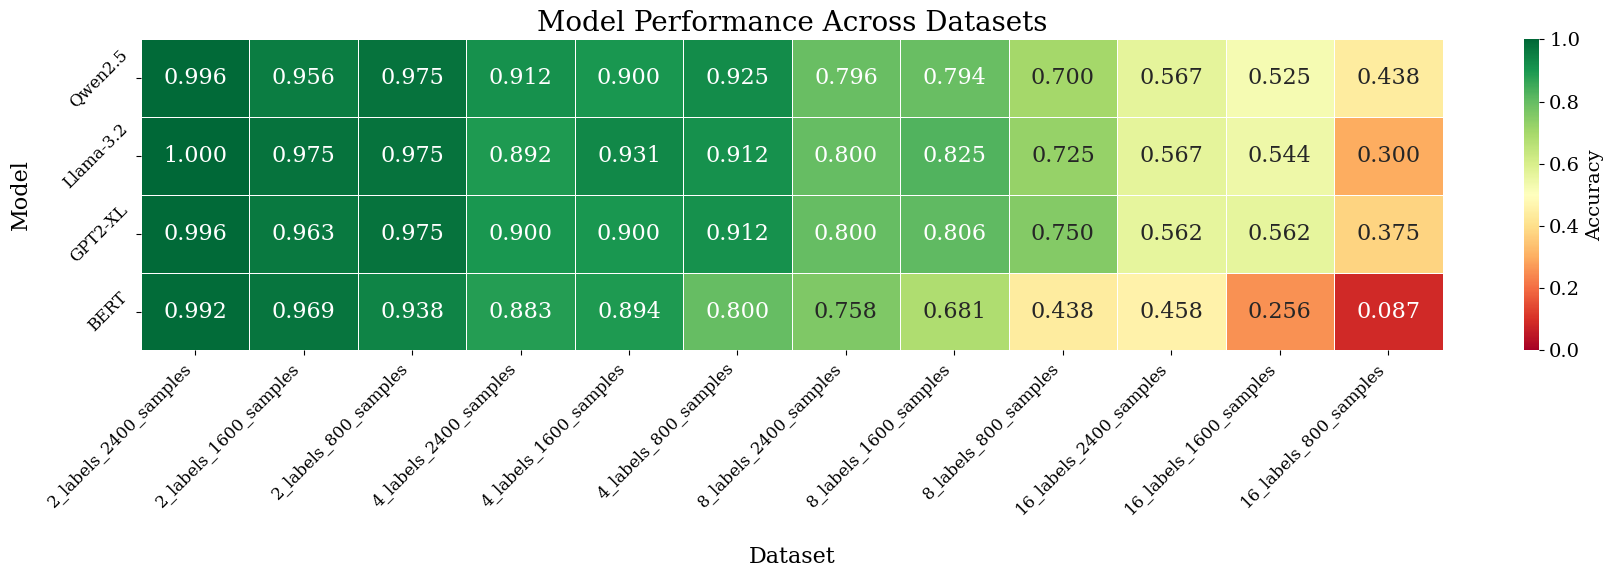

In [9]:
data = {
    "Model": ["Qwen2.5", "Llama-3.2", "GPT2-XL", "BERT"],
    "2_labels_2400_samples": [0.995833, 1.0, 0.995833, 0.991667],
    "2_labels_1600_samples": [0.95625, 0.975, 0.9625, 0.968750],
    "2_labels_800_samples": [0.975, 0.975, 0.975, 0.937500],
    "4_labels_2400_samples": [0.9125, 0.891667, 0.9, 0.883333],
    "4_labels_1600_samples": [0.9, 0.93125, 0.9, 0.893750],
    "4_labels_800_samples": [0.925, 0.9125, 0.9125, 0.800000],
    "8_labels_2400_samples": [0.795833, 0.8, 0.8, 0.758333],
    "8_labels_1600_samples": [0.79375, 0.825, 0.80625, 0.681250],
    "8_labels_800_samples": [0.7, 0.725, 0.75, 0.437500],
    "16_labels_2400_samples": [0.566667, 0.566667, 0.5625, 0.458333],
    "16_labels_1600_samples": [0.525, 0.54375, 0.5625, 0.256250],
    "16_labels_800_samples": [0.4375, 0.3, 0.375, 0.087500]
}

mpl.rcParams['font.family'] = 'Serif'  # or 'sans-serif', 'monospace', or a specific one like 'Arial', 'Times New Roman'
mpl.rcParams['font.size'] = 14   

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

plt.figure(figsize=(18, 6))
sns.heatmap(
    df,
    annot=True, fmt=".3f", linewidths=0.5,
    cmap="RdYlGn", cbar_kws={'label': 'Accuracy'},
    vmin=0.0, vmax=1.0,
    annot_kws={"size": 16}
)

plt.title("Model Performance Across Datasets", fontsize=20)
plt.xlabel("Dataset", fontsize=16, labelpad = 20)
plt.ylabel("Model", fontsize=16, labelpad = 20)
plt.xticks(rotation=45, ha="right", fontsize=12)  
plt.yticks(rotation=45, fontsize=12) 
plt.tight_layout()
plt.savefig("model_performance_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()